In [1]:
# Import Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
from geopy.geocoders import Nominatim
import time
from geopy.exc import GeocoderTimedOut

Import the Daily Shelter and Overnight Service Occupancy and Capacity dataset obtained from City of Toronto Open Data: https://open.toronto.ca/dataset/daily-shelter-overnight-service-occupancy-capacity/

In [4]:
# Import the daily shelter and overnight occupancy dataset as a dataframe
homeless_data = pd.read_csv('Data\Daily shelter overnight occupancy.csv')

In [5]:
# Preview the raw data
homeless_data.head()

,_id,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,...,OCCUPIED_BEDS,UNOCCUPIED_BEDS,UNAVAILABLE_BEDS,CAPACITY_ACTUAL_ROOM,CAPACITY_FUNDING_ROOM,OCCUPIED_ROOMS,UNOCCUPIED_ROOMS,UNAVAILABLE_ROOMS,OCCUPANCY_RATE_BEDS,OCCUPANCY_RATE_ROOMS
0,1,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1320.0,COSTI Hotel Program Dixon,640 Dixon Rd.,M9W 1J1,...,NaN,NaN,NaN,149.0,150.0,149.0,0.0,1.0,NaN,100.0
1,2,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1320.0,COSTI Hotel Program Dixon,640 Dixon Rd.,M9W 1J1,...,NaN,NaN,NaN,57.0,57.0,57.0,0.0,0.0,NaN,100.0
2,3,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1051.0,COSTI Reception Centre,100 Lippincott St,M5S 2P1,...,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN
3,4,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,...,NaN,NaN,NaN,67.0,83.0,67.0,0.0,16.0,NaN,100.0
4,5,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,...,NaN,NaN,NaN,161.0,148.0,161.0,0.0,0.0,NaN,100.0


## Clean the Data


In [6]:
# Inspect all the columns available in the raw data
homeless_data.columns

Index(['_id', 'OCCUPANCY_DATE', 'ORGANIZATION_ID', 'ORGANIZATION_NAME',
       'SHELTER_ID', 'SHELTER_GROUP', 'LOCATION_ID', 'LOCATION_NAME',
       'LOCATION_ADDRESS', 'LOCATION_POSTAL_CODE', 'LOCATION_CITY',
       'LOCATION_PROVINCE', 'PROGRAM_ID', 'PROGRAM_NAME', 'SECTOR',
       'PROGRAM_MODEL', 'OVERNIGHT_SERVICE_TYPE', 'PROGRAM_AREA',
       'SERVICE_USER_COUNT', 'CAPACITY_TYPE', 'CAPACITY_ACTUAL_BED',
       'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS',
       'UNAVAILABLE_BEDS', 'CAPACITY_ACTUAL_ROOM', 'CAPACITY_FUNDING_ROOM',
       'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS',
       'OCCUPANCY_RATE_BEDS', 'OCCUPANCY_RATE_ROOMS'],
      dtype='object')

Drop the Columns: 'CAPACITY_TYPE', 'CAPACITY_ACTUAL_BED',
       'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS',
       'UNAVAILABLE_BEDS', 'CAPACITY_ACTUAL_ROOM', 'CAPACITY_FUNDING_ROOM',
       'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS',
       'OCCUPANCY_RATE_BEDS', 'OCCUPANCY_RATE_ROOMS'
       
These do not provide further or relevant information.

In [7]:
# Drop the last 13 columns
homeless_data.drop(homeless_data.columns[-13:] ,axis = 1, inplace=True)

In [8]:
homeless_data.head()

,_id,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,LOCATION_PROVINCE,PROGRAM_ID,PROGRAM_NAME,SECTOR,PROGRAM_MODEL,OVERNIGHT_SERVICE_TYPE,PROGRAM_AREA,SERVICE_USER_COUNT
0,1,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1320.0,COSTI Hotel Program Dixon,640 Dixon Rd.,M9W 1J1,Toronto,ON,16892,COSTI - Hotel Program - Dixon (Refugee Families),Families,Emergency,Motel/Hotel Shelter,Temporary Refugee Response,650
1,2,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1320.0,COSTI Hotel Program Dixon,640 Dixon Rd.,M9W 1J1,Toronto,ON,16891,COSTI - Hotel Program - Dixon (Refugee Singles),Mixed Adult,Emergency,Motel/Hotel Shelter,Temporary Refugee Response,113
2,3,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1051.0,COSTI Reception Centre,100 Lippincott St,M5S 2P1,Toronto,ON,12251,COSTI Reception Centre CITY Program,Mixed Adult,Emergency,Shelter,Base Program - Refugee,8
3,4,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,North York,ON,15372,COSTI Uptown Hotel COVID-19 - Family Program,Families,Emergency,Motel/Hotel Shelter,Temporary Programs,203
4,5,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,North York,ON,13751,COSTI Uptown Hotel Family Program,Families,Emergency,Motel/Hotel Shelter,Temporary Refugee Response,508


It can be noticed from the PROGRAM_AREA column contains information such as Refugee Response programs. These are not the individuals that we are looking to model. Refugee programs do appear to usually be coorelated with OVERNIGHT_SERVICE_TYPE of Motel/Hotel Shelter; however, they could also be housed in basic Shelters as well. 

In [9]:
# Inspect the Columns to see all the unique datas
print(homeless_data['OVERNIGHT_SERVICE_TYPE'].unique())
print(homeless_data['PROGRAM_AREA'].unique())

['Motel/Hotel Shelter' 'Shelter' 'Warming Centre'
 'Isolation/Recovery Site' '24-Hour Respite Site'
 "24-Hour Women's Drop-in" 'Alternative Space Protocol'
 'Top Bunk Contingency Space']
['Temporary Refugee Response' 'Base Program - Refugee'
 'Temporary Programs' 'Base Shelter and Overnight Services System'
 'Winter Programs']


We will first try filtering by the PROGRAM_AREA column using the string Refugee.

In [10]:
# Remove rows where 'PROGRAM_AREA' contains the string 'Refugee'
homeless_data = homeless_data[~homeless_data['PROGRAM_AREA'].str.contains('Refugee', na=False)]

# Check the result
print(homeless_data['PROGRAM_AREA'].unique())
homeless_data.head()

['Temporary Programs' 'Base Shelter and Overnight Services System'
 'Winter Programs']


,_id,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,LOCATION_PROVINCE,PROGRAM_ID,PROGRAM_NAME,SECTOR,PROGRAM_MODEL,OVERNIGHT_SERVICE_TYPE,PROGRAM_AREA,SERVICE_USER_COUNT
3,4,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,North York,ON,15372,COSTI Uptown Hotel COVID-19 - Family Program,Families,Emergency,Motel/Hotel Shelter,Temporary Programs,203
5,6,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1160.0,CONC Etobicoke Hotel Program,445 Rexdale Blvd,M9W 6P8,Etobicoke,ON,16111,CONC Etobicoke Hotel Program - Mixed Adult,Mixed Adult,Emergency,Motel/Hotel Shelter,Temporary Programs,152
6,7,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1172.0,CONC West End Hotel Program,14 Roncesvalles Ave,M6R 2K3,Toronto,ON,15711,CONC Men's Hotel Program,Men,Emergency,Motel/Hotel Shelter,Temporary Programs,39
7,8,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1029.0,CONC Men's Shelter Lansdowne Ave,973 Lansdowne Ave,M6H 3Z5,Toronto,ON,12011,Christie Ossington Men's Hostel,Men,Emergency,Shelter,Base Shelter and Overnight Services System,42
8,9,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1102.0,CONC Men's Shelter Bloor St W,850 Bloor St W,M6G 1M2,Toronto,ON,13611,Christie Ossington Men's Hostel South,Men,Emergency,Shelter,Base Shelter and Overnight Services System,30


#### Missing Values

In [11]:
# Create a Series dataframe that shows the missing value counts for each columns
homeless_data_missing = homeless_data.isnull().sum().to_frame(name = 'count')

# View DataFrame
homeless_data_missing

,count
_id,0
OCCUPANCY_DATE,0
ORGANIZATION_ID,0
ORGANIZATION_NAME,0
SHELTER_ID,0
SHELTER_GROUP,0
LOCATION_ID,0
LOCATION_NAME,331
LOCATION_ADDRESS,1624
LOCATION_POSTAL_CODE,1624


The only missing data is related to location. This is problematic, as we require the LOCATION_ADDRESS or LOCATION_POSTAL_CODE to obtain the geographical coordinates of each shelter to plot on a folium map. Noticing that there are 0 LOCATION_ID missing values, perhaps we can fill in the other missing location columns using the values in said column. 

In [12]:
# Preview LOCATION_ID column values
homeless_data['LOCATION_ID'].unique()

array([1114., 1160., 1172., 1029., 1102., 1541., 1070., 1561., 1009.,
       1194., 1065., 1066., 1067., 1011., 1360., 1069., 1163., 1151.,
       1154., 1008., 1190., 1004., 1123., 1103., 1124., 1005., 1028.,
       1026., 1027., 1149., 1125., 1128., 1176., 1015., 1020., 1460.,
       1025., 1024., 1155., 1053., 1054., 1099., 1081., 1007., 1193.,
       1055., 1130., 1152., 1521., 1187., 1022., 1021., 1168., 1108.,
       1150., 1195., 1220., 1153., 1179., 1200., 1031., 1019., 1080.,
       1118., 1002., 1013., 1018., 1500., 1104., 1050., 1049., 1048.,
       1039., 1148., 1192., 1045., 1180., 1036., 1189., 1037., 1166.,
       1057., 1126., 1146., 1300., 1014., 1041., 1115., 1280., 1001.,
       1096., 1101., 1062., 1129., 1064., 1147., 1440., 1078.])

In [13]:
# Print rows with missing values in any column
missing_data_rows = homeless_data[homeless_data['LOCATION_ADDRESS'].isnull() | homeless_data['LOCATION_POSTAL_CODE'].isnull()]

# Display the rows with missing values
print(missing_data_rows['LOCATION_ID'].unique())
print(missing_data_rows['SHELTER_GROUP'].unique())
print(missing_data_rows['LOCATION_NAME'].unique())


[1163. 1187. 1280.]
['SSHA Etobicoke Hotel Program' 'Friends of Ruby' "Nellie's"]
['TSSS Etobicoke Hotel Program' 'Friends of Ruby' nan]


In [14]:
# Check to see if there are any rows in the homeless_data that have the same Location ID as the rows in missing_data_rows
for location in missing_data_rows['LOCATION_ID'].unique():
    print(homeless_data[(homeless_data['LOCATION_ID'] == location) & ((homeless_data['LOCATION_ADDRESS'].notna())
                                                               |(homeless_data['LOCATION_POSTAL_CODE'].notna()))].shape[0])

0
0
0


From this we can interpret that there are only 3 locations with missing data. We can then manually assign a dataframe for the missing values, so that we do not need to drop crucial data. 

In [15]:
# Define a mapping of shelter group names to their corresponding address details
address_mapping = {
    '1163': {
        'LOCATION_ADDRESS': '2180 Islington Ave',
        'LOCATION_NAME': 'TSSS Etobicoke Hotel Program',
        'LOCATION_POSTAL_CODE': 'M9P 3P1',
        'LOCATION_CITY': 'Toronto',
        'LOCATION_PROVINCE': 'ON'
    },
    '1187': {
        'LOCATION_ADDRESS': '489 Queen St E',
        'LOCATION_NAME': 'Friends of Ruby',
        'LOCATION_POSTAL_CODE': 'M5A 1V1',
        'LOCATION_CITY': 'Toronto',
        'LOCATION_PROVINCE': 'ON'
    },
    "1280": {
        'LOCATION_ADDRESS': '58 Cecil St',
        'LOCATION_NAME': "Nellie's",
        'LOCATION_POSTAL_CODE': 'M5T 1N6',
        'LOCATION_CITY': 'Toronto',
        'LOCATION_PROVINCE': 'ON'
    }
   
}

# Define the function to apply this mapping
def fill_address(row):
    shelter_group = row['SHELTER_GROUP']
    if shelter_group in address_mapping:
        return address_mapping[shelter_group]
    else:
        return {
            'LOCATION_ADDRESS': None,
            'LOCATION_NAME': None,
            'LOCATION_POSTAL_CODE': None,
            'LOCATION_CITY': None,
            'LOCATION_PROVINCE': None
        }

# Identify rows with missing address information
address_filled = homeless_data[homeless_data['LOCATION_ADDRESS'].isnull()]

# Apply the mapping to fill missing address columns
filled_address_data = address_filled.apply(fill_address, axis=1, result_type="expand")

# Update the original dataframe with the filled address data
homeless_data.loc[homeless_data['LOCATION_ADDRESS'].isnull(), ['LOCATION_ADDRESS', 'LOCATION_NAME', 'LOCATION_POSTAL_CODE', 'LOCATION_CITY', 'LOCATION_PROVINCE']] = filled_address_data[['LOCATION_ADDRESS', 'LOCATION_NAME', 'LOCATION_POSTAL_CODE', 'LOCATION_CITY', 'LOCATION_PROVINCE']].values

# Check the updated data (for example, print out the first few rows)
print(homeless_data[['SHELTER_GROUP', 'LOCATION_ADDRESS', 'LOCATION_CITY']].head())

                     SHELTER_GROUP     LOCATION_ADDRESS LOCATION_CITY
3           COSTI Reception Centre      55 Hallcrown Pl    North York
5  Christie Ossington Men's Hostel     445 Rexdale Blvd     Etobicoke
6  Christie Ossington Men's Hostel  14 Roncesvalles Ave       Toronto
7  Christie Ossington Men's Hostel    973 Lansdowne Ave       Toronto
8  Christie Ossington Men's Hostel       850 Bloor St W       Toronto


Display the cleaned homeless data.

In [16]:
homeless_data.head()

,_id,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,LOCATION_PROVINCE,PROGRAM_ID,PROGRAM_NAME,SECTOR,PROGRAM_MODEL,OVERNIGHT_SERVICE_TYPE,PROGRAM_AREA,SERVICE_USER_COUNT
3,4,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,North York,ON,15372,COSTI Uptown Hotel COVID-19 - Family Program,Families,Emergency,Motel/Hotel Shelter,Temporary Programs,203
5,6,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1160.0,CONC Etobicoke Hotel Program,445 Rexdale Blvd,M9W 6P8,Etobicoke,ON,16111,CONC Etobicoke Hotel Program - Mixed Adult,Mixed Adult,Emergency,Motel/Hotel Shelter,Temporary Programs,152
6,7,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1172.0,CONC West End Hotel Program,14 Roncesvalles Ave,M6R 2K3,Toronto,ON,15711,CONC Men's Hotel Program,Men,Emergency,Motel/Hotel Shelter,Temporary Programs,39
7,8,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1029.0,CONC Men's Shelter Lansdowne Ave,973 Lansdowne Ave,M6H 3Z5,Toronto,ON,12011,Christie Ossington Men's Hostel,Men,Emergency,Shelter,Base Shelter and Overnight Services System,42
8,9,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1102.0,CONC Men's Shelter Bloor St W,850 Bloor St W,M6G 1M2,Toronto,ON,13611,Christie Ossington Men's Hostel South,Men,Emergency,Shelter,Base Shelter and Overnight Services System,30


## Exploratory Data Analysis

In [17]:
homeless_data.dtypes

_id                         int64
OCCUPANCY_DATE             object
ORGANIZATION_ID             int64
ORGANIZATION_NAME          object
SHELTER_ID                  int64
SHELTER_GROUP              object
LOCATION_ID               float64
LOCATION_NAME              object
LOCATION_ADDRESS           object
LOCATION_POSTAL_CODE       object
LOCATION_CITY              object
LOCATION_PROVINCE          object
PROGRAM_ID                  int64
PROGRAM_NAME               object
SECTOR                     object
PROGRAM_MODEL              object
OVERNIGHT_SERVICE_TYPE     object
PROGRAM_AREA               object
SERVICE_USER_COUNT          int64
dtype: object

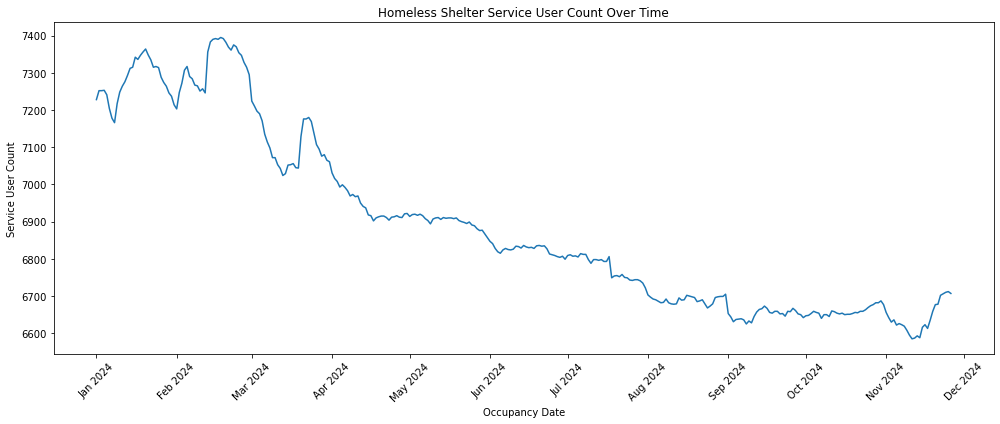

In [18]:
# Convert OCCUPANCY_DATE to datetime format
homeless_data['OCCUPANCY_DATE'] = pd.to_datetime(homeless_data['OCCUPANCY_DATE'])

# Group by 'OCCUPANCY_DATE' and sum 'SERVICE_USER_COUNT'
grouped_data = homeless_data.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].sum().reset_index()

# Create the line plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=grouped_data, x='OCCUPANCY_DATE', y='SERVICE_USER_COUNT')

# Add labels and title
plt.xlabel('Occupancy Date')
plt.ylabel('Service User Count')
plt.title('Homeless Shelter Service User Count Over Time')

# Format the x-axis to show months and years
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks at monthly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format ticks as 'Month Year'

# Rotate the date labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Show the plot
plt.show()

# Folium Plot of Shelters

In [19]:
# Create a list of all the addresses of the homeless shelters
shelter_addresses = homeless_data['LOCATION_ADDRESS'].unique().tolist()
print(shelter_addresses[:5])

['55 Hallcrown Pl', '445 Rexdale Blvd', '14 Roncesvalles Ave', '973 Lansdowne Ave', '850 Bloor St W']


In [20]:
# Initialize a geolocator with a timeout to address refresh rate issues when scraping for addresses
geolocator = Nominatim(user_agent="homeless_shelter_locator", timeout=10)

# Create a function to geocode every address, with retries in case of timeout failures
def geocode_address(address, retries=5, delay=1):
    for attempt in range(retries):
        # Use try and except to handle possible errors returned by geocode
        try:
            # Geocode with extra location constraints: restrict search to Toronto, Canada
            location = geolocator.geocode(address + ", Toronto, Canada")
            if location:
                return location.latitude, location.longitude
            else:
                # If geocoding fails, do not return anything
                return None, None 
        except GeocoderTimedOut:
            # Retry another attempt if geocoding fails, wait before immediately retrying
            time.sleep(delay)
        except Exception as e:
            # For any other error
            return None, None
    return None, None  # Return None if maximum 5 retries reached


In [21]:
# Create lists for the coordinates with associated address and a list for the addresses that failed to geocode
coordinates = []
failed_addresses = []

# Loop through all the shelter addresses and geocode the addresses

for address in shelter_addresses:
    lat, lon = geocode_address(address)
    
    # If Geocoding fails for the address, append the address to the failed_addresses list
    if lat is None and lon is None:
        failed_addresses.append(address)
        
    # Append the successfully geocoded addresses to the coordinates 
    coordinates.append((address, lat, lon))

print(coordinates[:5])  # Check the first few results to confirm the geocoding is correct

[('55 Hallcrown Pl', 43.7692665, -79.322408630854), ('445 Rexdale Blvd', 43.71604835, -79.59398958554878), ('14 Roncesvalles Ave', 43.63901885, -79.4465142944708), ('973 Lansdowne Ave', 43.6660985, -79.44601095079787), ('850 Bloor St W', 43.66244259375, -79.42414367500001)]


In [26]:
# Convert coordinates list to dictionary
address_dict = {address: (lat, lon) for address, lat, lon in coordinates}

In [30]:
# Convert address dictionary to a dataframe
address_df = pd.DataFrame(list(address_dict.items()), columns=['Address', 'Coordinates'])

# Reset index to make address a column
address_df.reset_index(inplace=True)
address_df.rename(columns={'index': 'Address'}, inplace=True)

address_df

,Address,Address,Coordinates
0,0,55 Hallcrown Pl,"(43.7692665, -79.322408630854)"
1,1,445 Rexdale Blvd,"(43.71604835, -79.59398958554878)"
2,2,14 Roncesvalles Ave,"(43.63901885, -79.4465142944708)"
3,3,973 Lansdowne Ave,"(43.6660985, -79.44601095079787)"
4,4,850 Bloor St W,"(43.66244259375, -79.42414367500001)"
...,...,...,...
90,90,348 Davenport Road,"(43.67530011065648, -79.40151870869647)"
91,91,6 Warrendale Ct,"(43.7363042, -79.5808276)"
92,92,747 Warden Ave,"(43.71752463333333, -79.2831322)"
93,93,58 Cecil Street,"(43.656442850000005, -79.39856448286824)"


In [22]:
# Print out failed addresses (if any)
if failed_addresses:
    print("Failed geocoding the following addresses:")
    for failed in failed_addresses:
        print(failed)

Failed geocoding the following addresses:
None


With the list of coordinates that relate to the addresses of each homeless shelter, *coordinates*, a folium map can be created with these coordinates plotted as markers.

In [23]:
# Create a Folium map centered around Toronto's coordinates
map_center = [43.67, -79.42] 
homeless_shelter_map = folium.Map(location=map_center, zoom_start=12)

# Loop through coordinates and add a red marker for each
for address, lat, lon in coordinates:
    if lat is not None and lon is not None:
        # Create a red marker
        folium.Marker(
            location=[lat, lon],
            popup=address,  # Popup with the address
            icon=folium.Icon(color='red', icon='info-sign', icon_color='white', prefix='fa')  # Red marker with white icon
        ).add_to(homeless_shelter_map)

# Save map to an HTML file to view
homeless_shelter_map.save("homeless_shelters_map.html")

# Preview the map
homeless_shelter_map

In [34]:
# Export to CSV
address_df.to_csv('Data\Address_df.csv', index = False)